# Building a Simple Support Agent using LangGraph and OpenAI

The purpose of this notebook is to show you how to build a simple agent using [LangGraph](https://github.com/langchain-ai/langgraph), and [OpenAI](https://openai.com/). The code is based on the ["Introduction to LangGraph"](https://langchain-ai.github.io/langgraph/tutorials/introduction/).

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

In [15]:
from os import environ

if not environ.get("OPENAI_API_KEY"):
    from getpass import getpass
    environ["OPENAI_API_KEY"] = getpass("OPENAI_API_KEY")

In [16]:
from functools import partial
from random import choices
from string import ascii_lowercase
from typing import Annotated
from typing_extensions import TypedDict

import gradio as gr

from IPython.display import Image, display
from langchain_core.messages import BaseMessage
from langchain_core.runnables import Runnable
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [17]:
# Define the state and its associated graph builder

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [18]:
# Define the chat model to use

llm = ChatOpenAI(model="gpt-4o")

In [19]:
# Define the tools, and bind the tools to the Runnablw

tool = DuckDuckGoSearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)

In [20]:
# Add the chatbot node

def chatbot(runnable: Runnable, state: State):
    return {"messages": [runnable.invoke(state["messages"])]}

# The first argument is the unique node name. The second argument is the function
# or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", partial(chatbot, llm_with_tools))

In [21]:
# Add tools node

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [22]:
# Compile the graph

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(checkpointer=memory)

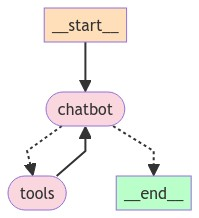

In [23]:
# Display graph

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
# Create the Gradio interface

def chat_interface_fn(
    compiled_graph: CompiledGraph,
    message: str,
    history: list[list[str]],  # We don't use the ChatInterface history
    thread_id: str
):
    """
    ChatInterface fn argument. This is invoked everytime the
    "Submit" button is pressed on the Gradio interface.
    """
    config = {"configurable": {"thread_id": thread_id}}
    for event in compiled_graph.stream(
        {"messages": ("user", message)},
        config=config
    ):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                yield value["messages"][-1].content
            

gr.ChatInterface(
    fn=partial(chat_interface_fn, graph),
    additional_inputs=[
        gr.Textbox("".join(choices(ascii_lowercase, k=8)), label="Thread ID"),
    ],
).launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
